<center>IE 7300: Statistical Learning for Engineering</center>

### <center>HW 6</center>
<center>Youyu Zhang</center>
<center>zhang.youy@northeastern.edu</center>
<center>(530)574-2826</center>
<center>Submitted by 10/25/2022</center>

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

from sklearn.metrics import confusion_matrix

Split the dataset into training and test dataset 80:20.


In [2]:
df = pd.read_csv('wine-1.csv')
df.head(3)

,Wine,Alcohol,Malic.acid,Ash,Acl,Mg,Phenols,Flavanoids,Nonflavanoid.phenols,Proanth,Color.int,Hue,OD,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185


In [3]:
x_all,y_all = np.array(df.drop('Wine', axis=1)), np.array(df['Wine'])
x_train, x_test = np.split(x_all,[int(0.8*len(x_all))])
y_train, y_test = np.split(y_all,[int(0.8*len(y_all))])

print('Training dataset length :', x_train.shape[0])
print('Testing dataset length :', x_test.shape[0])

Training dataset length : 142
Testing dataset length : 36


a) Create a logistics regression, LDA, decision tree, and AdaBoost models. Fit the model using the training dataset and find the model accuracy and confusion matrix. Explain each model's outcome, finding, and accuracy. (10 points) 

In [261]:
class LogisticRegression:
    """
    Logistic regression for multi-class classification.
    """
    def __init__(self, epochs: int=2000, threshold: float=1e-3) -> None:
        """
        epochs: iteration times
        threshold: threshold when the change of weights are less than
            this number, the iteration can stop.
        """
        self.epochs = epochs
        self.threshold = threshold

    def train(self, x, y, batch_size=64, lr=0.001):
        """
        Model training. 
        lr: learning rate
        batch_size: sample size
        """
        self.classes = np.unique(y)
        self.class_labels = {c:i for i,c in enumerate(self.classes)}
        # x = np.insert(x, 0, 1, axis=1)
        y = np.eye(len(self.classes))[np.vectorize(lambda c: self.class_labels[c])(y).reshape(-1)]
        self.loss = []
        self.weights = np.zeros(shape=(len(self.classes),x.shape[1]))
        i = 0
        while (not self.epochs or i < self.epochs):
            self.loss.append(self.cross_entropy(y, self.predict(x)))
            idx = np.random.choice(x.shape[0], batch_size)
            x_batch, y_batch = x[idx], y[idx]
            error = y_batch - self.predict(x_batch)
            update = (lr * np.dot(error.T, x_batch))
            self.weights = np.add(self.weights, update)
            # self.weights += update
            if np.abs(update).max() < self.threshold: 
                break
            if i % (self.epochs/5)  == 0: 
                print(' Training Accuray at {} iterations is {}'.format(i, self.evaluate_(x, y)))
            i +=1
        return self

    def predict(self, X):
        """
        Predict with given X. Return the softmax value.
        """
        # X = np.insert(X, 0, 1, axis=1)
        pre_vals = np.dot(X, self.weights.T).reshape(-1,len(self.classes))
        return self.softmax(pre_vals)
    
    def softmax(self, z):
        return np.exp(z.astype(float))/np.sum(np.exp(z.astype(float)), axis=1).reshape(-1,1)
    
    def evaluate_(self, X, y):
        return np.mean(np.argmax(self.predict(X), axis=1) == np.argmax(y, axis=1))

    def cross_entropy(self, y, probs):
        return -1 * np.mean(y * np.log(probs))

    def predict_proba(self, X):
        return self.predict(X)


In [5]:
class LinearDiscriminantAnalysis:
    """
    LDA
    """
    def __init__(self, n_components):
        """
        n_components: the number of components to yield
        linear_discriminants: eigenvector of the n_components
        """
        self.n_components = n_components
        self.linear_discriminants = None

    def fit(self, X, y):
        n_features = X.shape[1]
        class_labels = np.unique(y)

        mean_overall = np.mean(X, axis=0)
        # SW indicated within class scattering
        SW = np.zeros((n_features, n_features))
        # SB indicated the scattering between classes
        SB = np.zeros((n_features, n_features))

        for c in class_labels:
            X_c = X[y == c]
            mean_c = np.mean(X_c, axis=0)
            SW += (X_c - mean_c).T.dot((X_c - mean_c))
            n_c = X_c.shape[0]
            mean_diff = (mean_c - mean_overall).reshape(n_features, 1)
            SB += n_c * (mean_diff).dot(mean_diff.T)

        # Determine SW^-1 * SB
        A = np.linalg.inv(SW).dot(SB)
        # Get eigenvalues and eigenvectors of SW^-1 * SB
        eigenvalues, eigenvectors = np.linalg.eig(A)
        # -> eigenvector v = [:,i] column vector, transpose for easier calculations
        # sort eigenvalues high to low
        eigenvectors = eigenvectors.T
        idxs = np.argsort(abs(eigenvalues))[::-1]
        eigenvalues = eigenvalues[idxs]
        eigenvectors = eigenvectors[idxs]
        # store first n eigenvectors
        self.linear_discriminants = eigenvectors[0 : self.n_components]

    def transform(self, X):
        # project data
        return np.dot(X, self.linear_discriminants.T)


In [608]:
class Node():
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, var_red=None, value=None):
        # for decision node
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.var_red = var_red
        
        # for leaf node
        self.value = value


class DecisionTree():
    """
    This class includes two different decision tree method:
    1. regressor, methodName 
    2. classification, methodName_
    """
    def __init__(self, min_samples_split=2, max_depth=2):
        # initialize the root of the tree 
        self.root = None
        # stopping conditions
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        
    def build_tree(self, dataset, curr_depth=0):  
        """
        Regressor build
        """
        X, Y = dataset[:,:-1], dataset[:,-1]
        num_samples, num_features = np.shape(X)
        best_split = {}
        # split until stopping conditions are met
        if num_samples>=self.min_samples_split and curr_depth<=self.max_depth:
            # find the best split
            best_split = self.get_best_split(dataset, num_samples, num_features)
            # check if information gain is positive
            if best_split["var_red"]>0:
                # recur left
                left_subtree = self.build_tree(best_split["dataset_left"], curr_depth+1)
                # recur right
                right_subtree = self.build_tree(best_split["dataset_right"], curr_depth+1)
                # return decision node
                return Node(best_split["feature_index"], best_split["threshold"], 
                            left_subtree, right_subtree, best_split["var_red"])
        # compute leaf node
        leaf_value = self.calculate_leaf_value(Y)
        # return leaf node
        return Node(value=leaf_value)

    def build_tree_(self, dataset, curr_depth=0,sample_weight=None):
        """
        Classification build
        """
        if sample_weight is not None:
            X, Y, sample_weight = dataset[:,:-2], dataset[:,-2], dataset[-1]
        else:
            X, Y = dataset[:,:-1], dataset[:,-1]
        num_samples, num_features = np.shape(X)
        
        # split until stopping conditions are met
        if num_samples>=self.min_samples_split and curr_depth<=self.max_depth:
            # find the best split
            best_split = self.get_best_split_(dataset, num_samples, num_features,sample_weight=None)
            # check if information gain is positive
            if best_split["info_gain"]>0:
                # recur left
                left_subtree = self.build_tree_(best_split["dataset_left"], curr_depth+1)
                # recur right
                right_subtree = self.build_tree_(best_split["dataset_right"], curr_depth+1)
                # return decision node
                return Node(best_split["feature_index"], best_split["threshold"], 
                            left_subtree, right_subtree, best_split["info_gain"])
        
        # compute leaf node
        leaf_value = self.calculate_leaf_value_(Y)
        # return leaf node
        return Node(value=leaf_value)
    
    def get_best_split(self, dataset, num_samples, num_features):
        ''' function to find the best split '''
        
        # dictionary to store the best split
        best_split = {}
        max_var_red = -float("inf")
        # loop over all the features
        for feature_index in range(num_features):
            feature_values = dataset[:, feature_index]
            possible_thresholds = np.unique(feature_values)
            # loop over all the feature values present in the data
            for threshold in possible_thresholds:
                # get current split
                dataset_left, dataset_right = self.split(dataset, feature_index, threshold)
                # check if childs are not null
                if len(dataset_left)>0 and len(dataset_right)>0:
                    y, left_y, right_y = dataset[:, -1], dataset_left[:, -1], dataset_right[:, -1]
                    # compute information gain
                    curr_var_red = self.variance_reduction(y, left_y, right_y)
                    # update the best split if needed
                    if curr_var_red>max_var_red:
                        best_split["feature_index"] = feature_index
                        best_split["threshold"] = threshold
                        best_split["dataset_left"] = dataset_left
                        best_split["dataset_right"] = dataset_right
                        best_split["var_red"] = curr_var_red
                        max_var_red = curr_var_red
                        
        # return best split
        return best_split
    
    def get_best_split_(self, dataset, num_samples, num_features,sample_weight=None):
        ''' function to find the best split '''
        
        # dictionary to store the best split
        best_split = {}
        max_info_gain = -float("inf")
        
        # loop over all the features
        for feature_index in range(num_features):
            feature_values = dataset[:, feature_index]
            possible_thresholds = np.unique(feature_values)
            # loop over all the feature values present in the data
            for threshold in possible_thresholds:
                # get current split
                dataset_left, dataset_right = self.split(dataset, feature_index, threshold)
                # check if childs are not null
                if len(dataset_left)>0 and len(dataset_right)>0:
                    if sample_weight == None:
                        y, left_y, right_y = dataset[:, -1], dataset_left[:, -1], dataset_right[:, -1]
                        curr_info_gain = self.information_gain(
                        parent=y,
                        l_child=left_y,
                        r_child=right_y,
                        mode="gini",
                        sample_weight=None
                        )
                    else:
                        y, left_y, right_y = dataset[:, -2], dataset_left[:, -2], dataset_right[:, -2]
                        weight, left_weight, right_weight = dataset[:, -1], dataset_left[:, -1], dataset_right[:, -1]
                        # compute information gain
                        curr_info_gain = self.information_gain(
                            parent=y,
                            l_child=left_y,
                            r_child=right_y,
                            mode="gini",
                            sample_weight=[weight, left_weight, right_weight]
                            )
                    # update the best split if needed
                    if curr_info_gain>max_info_gain:
                        best_split["feature_index"] = feature_index
                        best_split["threshold"] = threshold
                        best_split["dataset_left"] = dataset_left
                        best_split["dataset_right"] = dataset_right
                        best_split["info_gain"] = curr_info_gain
                        max_info_gain = curr_info_gain
                        
        # return best split
        return best_split

    def split(self, dataset, feature_index, threshold):
        dataset_left = np.array([row for row in dataset if row[feature_index]<=threshold])
        dataset_right = np.array([row for row in dataset if row[feature_index]>threshold])
        return dataset_left, dataset_right
    
    def variance_reduction(self, parent, l_child, r_child):
        weight_l = len(l_child) / len(parent)
        weight_r = len(r_child) / len(parent)
        reduction = np.var(parent) - (weight_l * np.var(l_child) + weight_r * np.var(r_child))
        return reduction

    def information_gain(self, parent, l_child, r_child, mode="entropy",sample_weight=None):
        ''' function to compute information gain '''
        if sample_weight == None:
            weight_l = len(l_child) / len(parent)
            weight_r = len(r_child) / len(parent)
            if mode=="gini":
                gain = self.gini_index(parent) - (weight_l*self.gini_index(l_child) + weight_r*self.gini_index(r_child))
            else:
                gain = self.entropy(parent) - (weight_l*self.entropy(l_child) + weight_r*self.entropy(r_child))
        else:
            parent_weight = sample_weight[0]
            weight_l = sample_weight[1]
            weight_r = sample_weight[2]
            if mode=="gini":
                gain = self.gini_index(parent,parent_weight) - (self.gini_index(l_child,weight_l) + self.gini_index(r_child,weight_r))
            else:
                gain = self.entropy(parent) - (weight_l*self.entropy(l_child) + weight_r*self.entropy(r_child))
        return gain

    def entropy(self, y, sample_weight=None):
        """
        Function to calculate entropy
        """
        class_labels = np.unique(y)
        entropy = 0
        for cls in class_labels:
            p_cls = len(y[y == cls]) / len(y)
            entropy += -p_cls * np.log2(p_cls)
        return entropy

    def gini_index(self, y, sample_weight=None):
        '''
        Function to compute gini index 
        Weighted added. 
        '''
        class_labels = np.unique(y)
        gini = 0

        if sample_weight == None:
            for cls in class_labels:
                p_cls = len(y[y == cls]) / len(y)
                gini += p_cls**2
        else:  # Not weighted
            # Check if y and sample_weight has same length
            if len(y) != len(sample_weight):
                print('Length of y and sample_weight do not match.')
            # Normalize weight before calculation
            ss = sum(sample_weight)
            norm_weight = [i/ss for i in sample_weight]
            for cls in class_labels:
                ind = []
                p_cls_items = []
                for idx, value in enumerate(y):
                    if value == cls:
                        ind.append(idx)
                        p_cls_items.append(norm_weight[idx])
                p_cls = sum(p_cls_items)
                gini += p_cls**2

        return 1 - gini
        
    def calculate_leaf_value_(self, Y):
        Y = list(Y)
        return max(Y, key=Y.count)

    def calculate_leaf_value(self, Y):
        val = np.mean(Y)
        return val
                
    def print_tree(self, tree=None, indent=" "):
        if not tree:
            tree = self.root
        if tree.value is not None:
            print(tree.value)
        else:
            print("X_"+str(tree.feature_index), "<=", tree.threshold, "?", tree.var_red)
            print("%sleft:" % (indent), end="")
            self.print_tree(tree.left, indent + indent)
            print("%sright:" % (indent), end="")
            self.print_tree(tree.right, indent + indent)
    
    def fit_(self, X, Y):
        """
        Fit for regression.
        """
        # dataset = np.concatenate((X, Y), axis=1)
        dataset = np.concatenate((X,np.array(Y).reshape(len(Y),1)),axis=1)
        self.root = self.build_tree(dataset)
        
    def fit(self, X, Y, sample_weight=None):
        """
        Fit for classification.
        """
        # dataset = np.concatenate((X, Y), axis=1)
        dataset = np.concatenate((X,np.array(Y).reshape(len(Y),1)),axis=1)
        if sample_weight is not None:
            dataset = np.concatenate((dataset,np.array(sample_weight).reshape(len(sample_weight),1)),axis=1)
            self.root = self.build_tree_(dataset, sample_weight=sample_weight)
        self.root = self.build_tree_(dataset)

    def make_prediction(self, x, tree):
        if tree.value!=None: return tree.value
        feature_val = x[tree.feature_index]
        if feature_val<=tree.threshold:
            return self.make_prediction(x, tree.left)
        else:
            return self.make_prediction(x, tree.right)
    
    def predict(self, X): 
        preditions = [self.make_prediction(x, self.root) for x in X]
        return preditions

In [602]:
from copy import deepcopy

class AdaBoostClassifier(object):
    '''
    Parameters
    -----------
    base_estimator: object
        The base model from which the boosted ensemble is built.
    n_estimators: integer, optional(default=50)
        The maximum number of estimators
    learning_rate: float, optional(default=1)
    algorithm: {'SAMME','SAMME.R'}, optional(default='SAMME.R')
        SAMME.R uses predicted probabilities to update wights, while SAMME uses class error rate
    random_state: int or None, optional(default=None)
    Attributes
    -------------
    estimators_: list of base estimators
    estimator_weights_: array of floats
        Weights for each base_estimator
    estimator_errors_: array of floats
        Classification error for each estimator in the boosted ensemble.
    Reference:
    1. [multi-adaboost](https://web.stanford.edu/~hastie/Papers/samme.pdf)
    2. [scikit-learn:weight_boosting](https://github.com/scikit-learn/
    scikit-learn/blob/51a765a/sklearn/ensemble/weight_boosting.py#L289)
    '''

    def __init__(self, *args, **kwargs):
        if kwargs and args:
            raise ValueError(
                '''AdaBoostClassifier can only be called with keyword
                   arguments for the following keywords: base_estimator ,n_estimators,
                    learning_rate,algorithm,random_state''')
        allowed_keys = [
            'base_estimator', 'n_estimators', 
            'learning_rate', 'algorithm', 'random_state'
            ]
        keywords_used = kwargs.keys()
        for keyword in keywords_used:
            if keyword not in allowed_keys:
                raise ValueError(keyword + ":  Wrong keyword used --- check spelling")

        n_estimators = 50
        learning_rate = 1
        algorithm = 'SAMME.R'
        random_state = None

        if kwargs and not args:
            if 'base_estimator' in kwargs:
                base_estimator = kwargs.pop('base_estimator')
            else:
                raise ValueError('''base_estimator can not be None''')
            if 'n_estimators' in kwargs: 
                n_estimators = kwargs.pop('n_estimators')
            if 'learning_rate' in kwargs: 
                learning_rate = kwargs.pop('learning_rate')
            if 'algorithm' in kwargs: 
                algorithm = kwargs.pop('algorithm')
            if 'random_state' in kwargs: 
                random_state = kwargs.pop('random_state')

        self.base_estimator_ = base_estimator
        self.n_estimators_ = n_estimators
        self.learning_rate_ = learning_rate
        self.algorithm_ = algorithm
        self.random_state_ = random_state
        self.estimators_ = list()
        self.estimator_weights_ = np.zeros(self.n_estimators_)
        self.estimator_errors_ = np.ones(self.n_estimators_)


    def _samme_proba(self, estimator, n_classes, X):
        """Calculate algorithm 4, step 2, equation c) of Zhu et al [1].
        References
        ----------
        .. [1] J. Zhu, H. Zou, S. Rosset, T. Hastie, "Multi-class AdaBoost", 2009.
        """
        proba = estimator.predict_proba(X)

        # Displace zero probabilities so the log is defined.
        # Also fix negative elements which may occur with
        # negative sample weights.
        proba[proba < np.finfo(proba.dtype).eps] = np.finfo(proba.dtype).eps
        log_proba = np.log(proba)

        return (n_classes - 1) * (log_proba - (1. / n_classes)
                                  * log_proba.sum(axis=1)[:, np.newaxis])


    def fit(self, X, y):
        self.n_samples = X.shape[0]
        # There is hidden trouble for classes, here the classes will be sorted.
        # So in boost we have to ensure that the predict results have the same classes sort
        self.classes_ = np.array(sorted(list(set(y))))
        self.n_classes_ = len(self.classes_)
        for iboost in range(self.n_estimators_):
            if iboost == 0:
                sample_weight = np.ones(self.n_samples) / self.n_samples

            sample_weight, estimator_weight, estimator_error = self.boost(X, y, sample_weight)

            # early stop
            if estimator_error == None:
                break

            # append error and weight
            self.estimator_errors_[iboost] = estimator_error
            self.estimator_weights_[iboost] = estimator_weight

            if estimator_error <= 0:
                break

        return self


    def boost(self, X, y, sample_weight):
        if self.algorithm_ == 'SAMME':
            return self.discrete_boost(X, y, sample_weight)
        elif self.algorithm_ == 'SAMME.R':
            return self.real_boost(X, y, sample_weight)

    def real_boost(self, X, y, sample_weight):
        estimator = deepcopy(self.base_estimator_)
        if self.random_state_:
            estimator.set_params(random_state=1)

        estimator.train(X, y)

        y_pred = estimator.predict(X)
        incorrect = y_pred != y
        estimator_error = np.dot(incorrect, sample_weight) / np.sum(sample_weight, axis=0)

        # if worse than random guess, stop boosting
        # if estimator_error.all() >= 1.0 - 1 / self.n_classes_:
        #     return None, None, None

        y_predict_proba = estimator.predict_proba(X)
        # repalce zero
        y_predict_proba[y_predict_proba < np.finfo(y_predict_proba.dtype).eps] = np.finfo(y_predict_proba.dtype).eps

        y_codes = np.array([-1. / (self.n_classes_ - 1), 1.])
        y_coding = y_codes.take(self.classes_ == y[:, np.newaxis])

        # for sample weight update
        intermediate_variable = (-1. * self.learning_rate_ * (((self.n_classes_ - 1) / self.n_classes_) *
                                                              inner1d(y_coding, np.log(
                                                                  y_predict_proba))))  #dot iterate for each row

        # update sample weight
        sample_weight *= np.exp(intermediate_variable)

        sample_weight_sum = np.sum(sample_weight, axis=0)
        if sample_weight_sum <= 0:
            return None, None, None

        # normalize sample weight
        sample_weight /= sample_weight_sum

        # append the estimator
        self.estimators_.append(estimator)

        return sample_weight, 1, estimator_error


    def discrete_boost(self, X, y, sample_weight):
        estimator = deepcopy(self.base_estimator_)
        if self.random_state_:
            estimator.set_params(random_state=1)

        estimator.fit(X, y, sample_weight=sample_weight)

        y_pred = estimator.predict(X)
        incorrect = y_pred != y
        estimator_error = np.dot(incorrect, sample_weight) / np.sum(sample_weight, axis=0)

        # if worse than random guess, stop boosting
        if estimator_error >= 1 - 1 / self.n_classes_:
            return None, None, None

        # update estimator_weight
        estimator_weight = self.learning_rate_ * np.log((1 - estimator_error) / estimator_error) + np.log(
            self.n_classes_ - 1)

        if estimator_weight <= 0:
            return None, None, None

        # update sample weight
        sample_weight *= np.exp(estimator_weight * incorrect)

        sample_weight_sum = np.sum(sample_weight, axis=0)
        if sample_weight_sum <= 0:
            return None, None, None

        # normalize sample weight
        sample_weight /= sample_weight_sum

        # append the estimator
        self.estimators_.append(estimator)

        return sample_weight, estimator_weight, estimator_error

    def predict(self, X):
        n_classes = self.n_classes_
        classes = self.classes_[:, np.newaxis]
        pred = None

        if self.algorithm_ == 'SAMME.R':
            # The weights are all 1. for SAMME.R
            pred = sum(self._samme_proba(estimator, n_classes, X) for estimator in self.estimators_)
        else:  # self.algorithm == "SAMME"
            pred = sum((estimator.predict(X) == classes).T * w
                       for estimator, w in zip(self.estimators_,
                                               self.estimator_weights_))

        pred /= self.estimator_weights_.sum()
        if n_classes == 2:
            pred[:, 0] *= -1
            pred = pred.sum(axis=1)
            return self.classes_.take(pred > 0, axis=0)

        return self.classes_.take(np.argmax(pred, axis=1), axis=0)


    def predict_proba(self, X):
        if self.algorithm_ == 'SAMME.R':
            # The weights are all 1. for SAMME.R
            proba = sum(self._samme_proba(estimator, self.n_classes_, X)
                        for estimator in self.estimators_)
        else:  # self.algorithm == "SAMME"
            proba = sum(estimator.predict_proba(X) * w
                        for estimator, w in zip(self.estimators_,
                                                self.estimator_weights_))

        proba /= self.estimator_weights_.sum()
        proba = np.exp((1. / (self.n_classes - 1)) * proba)
        normalizer = proba.sum(axis=1)[:, np.newaxis]
        normalizer[normalizer == 0.0] = 1.0
        proba /= normalizer

        return proba

In [502]:
# Define AdaBoost class
def compute_error(y, y_pred, w_i):
    '''
    Calculate the error rate of a weak classifier m. Arguments:
    y: actual target value
    y_pred: predicted value by weak classifier
    w_i: individual weights for each case
    
    Note that all arrays should be the same length
    '''
    return (sum(w_i * (np.not_equal(y, y_pred)).astype(int)))/sum(w_i)

def compute_alpha(error):
    '''
    Calculate the weight of a weak classifier m in the majority vote of the final classifier. This is called
    alpha in chapter 10.1 of The Elements of Statistical Learning. Arguments:
    error: error rate from weak classifier m
    '''
    return np.log((1 - error) / error)

def update_weights(w_i, alpha, y, y_pred):
    ''' 
    Update individual weights w_i after a boosting iteration. Arguments:
    w_i: individual weights for each observation
    y: actual target value
    y_pred: predicted value by weak classifier  
    alpha: weight of weak classifier used to estimate y_pred
    '''  
    return w_i * np.exp(alpha * (np.not_equal(y, y_pred)).astype(int))

class Ada:
    """
    
    """
    def __init__(self, base_estimator=DecisionTree(max_depth = 3)):
        '''
        Ada constructor
        base_estimator: 
        '''
        self.base_estimator = base_estimator
        self.alphas = []
        self.G_M = []
        self.M = None
        self.training_errors = []
        self.prediction_errors = []

    def fit(self, X, y, M = 100):
        '''
        Fit model. Arguments:
        X: independent variables - array-like matrix
        y: target variable - array-like vector
        '''
        
        # Clear before calling
        self.alphas = [] 
        self.training_errors = []
        self.M = M

        # Iterate over M weak classifiers
        for m in range(0, M):
            
            # Set weights for current boosting iteration
            if m == 0:
                w_i = np.ones(len(y)) * 1 / len(y)  # At m = 0, weights are all the same and equal to 1 / N
            else:
                # (d) Update w_i
                w_i = update_weights(w_i, alpha_m, y, y_pred)
            
            # (a) Fit weak classifier and predict labels
            G_m = self.base_estimator   # Stump: Two terminal-node classification tree
            G_m.fit(X, y, sample_weight = w_i)
            y_pred = G_m.predict(X)
            
            self.G_M.append(G_m) # Save to list of weak classifiers

            # (b) Compute error
            error_m = compute_error(y, y_pred, w_i)
            self.training_errors.append(error_m)

            # (c) Compute alpha
            alpha_m = compute_alpha(error_m)
            self.alphas.append(alpha_m)

        assert len(self.G_M) == len(self.alphas)

    def predict(self, X):
        '''
        Predict using fitted model. Arguments:
        X: independent variables - array-like
        '''

        # Initialise dataframe with weak predictions for each observation
        weak_preds = pd.DataFrame(index = range(len(X)), columns = range(self.M)) 

        # Predict class label for each weak classifier, weighted by alpha_m
        for m in range(self.M):
            y_pred_m = []
            pred = self.G_M[m].predict(X)
            for i in range(len(pred)):
                y_pred_m.append(pred[i]*self.alphas[m])
            weak_preds.iloc[:,m] = y_pred_m

        # Calculate final predictions
        y_pred = (1 * np.sign(weak_preds.T.sum())).astype(int)

        return y_pred, weak_preds

Logistic Regression prediction of the training dataset.

In [246]:
lr = LogisticRegression(epochs=5000)
lr.train(x_train,y_train, lr=1e-6)

 Training Accuray at 0 iterations is 0.4154929577464789


Convert the probability of each case into the final prediction of classification. 

In [159]:
def category_pointer(y_cat, y_pred):
    """
    This function translate numerical training result to categorical.
    It also summarize which class the prediction indicated.
    """
    ind = y_pred.argmax(axis=1)
    y_class = []
    y_pointer = list(enumerate(np.unique(y_cat)))
    for i in range(len(ind)):
        y_class.append(y_pointer[ind[i]][1])
    return y_class

In [249]:
# y_pred_train = lr.predict(np.insert(x_train, 0, 1, axis=1))
y_pred_train = lr.predict(x_train)
y_pred_train = category_pointer(y_cat=y_train,y_pred=y_pred_train)

The following confusion matrix indicated that some of the cases are not correctly classified. The accuracy of the model is 82.4%. As for class=3, it did not predict correctly at all. The reason of the misclassification can be the uneven dataset split. 

In [250]:
confusion_matrix(y_true=y_train, y_pred=y_pred_train)

array([[52,  7,  0],
       [ 7, 64,  0],
       [ 3,  9,  0]], dtype=int64)

In [168]:
def accuracy(y_pred, y_true):
    return round(np.sum(y_pred==y_true)/len(y_true),4)

accuracy(y_pred=y_pred_train, y_true=y_train)

0.8239

Fit LDA and Project Visualization

In [170]:
# Project the data onto the 2 primary linear discriminants
ldaModel = LinearDiscriminantAnalysis(2)
ldaModel.fit(x_train, y_train)
x_projected = ldaModel.transform(x_train)

print("Shape of X:", x_train.shape)
print("Shape of transformed X:", x_projected.shape)

Shape of X: (142, 13)
Shape of transformed X: (142, 2)


The visualization illustrated the 3 classes of cases distributed in the 2 major discriminant component. When the linear discriminant 1 is less than -8, it would probably be the same group. Otherwise, linear component 2 = 1.5 can be a divider for the other 2 groups.

This division figure looks effective and clean. No overlap or misclassification cases appeared.

c:\Users\youyu\AppData\Local\Programs\Python\Python38\lib\site-packages\matplotlib\collections.py:206: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


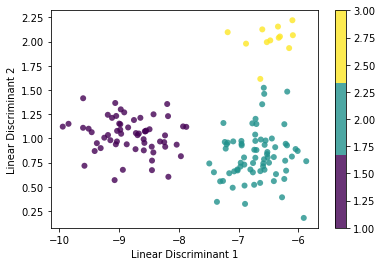

In [171]:
x1, x2 = x_projected[:, 0], x_projected[:, 1]

plt.scatter(
    x_projected[:, 0], x_projected[:, 1], c=y_train, edgecolor="none", alpha=0.8, cmap=plt.cm.get_cmap("viridis", 3)
)

plt.xlabel("Linear Discriminant 1")
plt.ylabel("Linear Discriminant 2")
plt.colorbar()
plt.show()

Decision Tree

Decision tree prediction of training dataset reach 100% correct. The reason that it makes 100% correct is because decision tree has already classify each case by the conditions. If the max_depth is not too small, it will definitely classify each case into correct value. 

The cons is, such classification may not work as well in testing dataset as it used for training dataset. Since the training dataset and fitting process recorded too much (maybe not necessary) information about how to split the data and build the tree, overfitting can be a serious issue.

In [561]:
dtclf = DecisionTree(min_samples_split=2, max_depth=4)
dtclf.fit(x_train,y_train)
y_pred_dtclf = dtclf.predict(x_train)

confusion_matrix(y_true=y_train, y_pred=y_pred_dtclf)

array([[59,  0,  0],
       [ 0, 71,  0],
       [ 0,  0, 12]], dtype=int64)

AdaBoost Training & Prediction

Use Decision Tree with max depth 2 as a base estimator. Set the default of boosting time as 3. 

The results shows that the accuracy is 41.55% which is not ideal for prediction. class=1 cases are all correctly predicted, but the other 2 types are not correctly predicted.


In [609]:
adaclf = AdaBoostClassifier(
    base_estimator=DecisionTree(max_depth=3),
    n_estimators = 10,
    learning_rate = 0.001,
    algorithm = 'SAMME'
    )

initial_weight = [1/len(x_train)]*len(x_train)
adaclf.fit(x_train, y_train)

In [568]:
y_pred_adaclf = adaclf.predict(x_train)

confusion_matrix(y_true=y_train, y_pred=y_pred_adaclf)

array([[57,  2,  0],
       [ 0, 71,  0],
       [ 0,  0, 12]], dtype=int64)

In [514]:
ab = Ada(base_estimator=DecisionTree(min_samples_split=3,max_depth=2))
ab.fit(x_train, y_train, M=3)

In [516]:
y_pred_ab, weak_preds = ab.predict(x_train)

print(accuracy(y_pred=y_pred_ab, y_true=y_train)*100)

confusion_matrix(y_true=y_train, y_pred=y_pred_ab)

41.55


array([[59,  0,  0],
       [71,  0,  0],
       [12,  0,  0]], dtype=int64)

b) Predict the models using the test dataset, and provide the performance metrics. Compare the five models' performance metrics, and explain at least four findings on each of the models. Do not need to repeat the code). (10 points)

Comparing the accuracy and confusion matrix, the performance on logistic regression did not predict correctly at all. 

The reason can be the Y differences between training and testing data. 

The training data contains a lot of class=1 and class=2. However, the testing data are all class=3. Such difference will degrade the training weights. 

In [224]:
y_pred_test_lr = lr.predict(np.insert(x_test, 0, 1, axis=1))
y_pred_test_lr = category_pointer(y_cat=y_train,y_pred=y_pred_test_lr)

accuracy(y_pred=y_pred_test_lr, y_true=y_test)

0.0

In [226]:
confusion_matrix(y_true=y_test, y_pred=y_pred_test_lr)

array([[ 0,  0,  0],
       [ 0,  0,  0],
       [ 2, 34,  0]], dtype=int64)

In [229]:
y_test

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], dtype=int64)

The LDA project could not devide the categories in testing data, because the testing data only have class=3, and thus LDA could not separate classes as far as possible. 

In this graph, the only category in the test dataset is class=3, and we don't have any other group to separated from. 

Shape of X: (36, 2)
Shape of transformed X: (36, 2)


c:\Users\youyu\AppData\Local\Programs\Python\Python38\lib\site-packages\matplotlib\collections.py:206: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


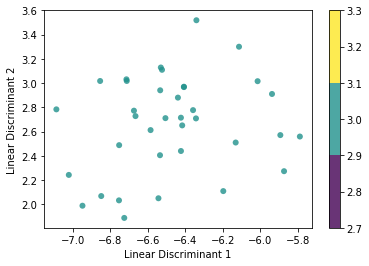

In [232]:
y_project_test = ldaModel.transform(x_test)
print("Shape of X:", y_project_test.shape)
print("Shape of transformed X:", y_project_test.shape)

x1, x2 = y_project_test[:, 0], y_project_test[:, 1]

plt.scatter(
    x1, x2, c=y_test, edgecolor="none", alpha=0.8, cmap=plt.cm.get_cmap("viridis", 3)
)

plt.xlabel("Linear Discriminant 1")
plt.ylabel("Linear Discriminant 2")
plt.colorbar()
plt.show()

The Decision Tree prediction result are described below.

The accuracy is 75%, which is much higher than 0% from logistic regression. The reason it was higher is because decision tree has better performance on extreme cases. 

In [271]:
y_pred_test_dtclf = dtclf.predict(x_test)

confusion_matrix(y_true=y_test, y_pred=y_pred_test_dtclf)

array([[ 0,  0,  0],
       [ 0,  0,  0],
       [ 4,  5, 27]], dtype=int64)

In [266]:
accuracy(y_pred=y_pred_test_dtclf, y_true=y_test)

0.75

AdaBoost with Decision Tree as a base estimator will result 0 in accuracy. Because none of the test cases including class=1. This AdaBoost model did not work well on class=3 prediction.

In [556]:
y_pred_test_adaclf = adaclf.predict(x_test)

accuracy(y_true=y_test, y_pred=y_pred_test_adaclf)

0.75

In [518]:
y_pred_test_ab = ab.predict(x_test)

accuracy(y_true=y_test, y_pred=y_pred_test_ab)

C:\Users\youyu\AppData\Local\Temp/ipykernel_4248/3908507820.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return round(np.sum(y_pred==y_true)/len(y_true),4)
C:\Users\youyu\AppData\Local\Temp/ipykernel_4248/3908507820.py:2: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  return round(np.sum(y_pred==y_true)/len(y_true),4)


0.0

c) Do you see any overfitting and underfitting issues on each model? How to overcome the overfitting/underfitting issues in your custom models? Provide the information model by model. (10 points)

Yes, all models, except AdaBoost, have overfitting issues. It was mainly because the data split part did not separate data and classes well. Thus the training dataset does not include class=3 cases, and training process does not have records for class=3. When we predict the testing data with training records, it would be hard to find a good match and classification. 

In order to overcome this issue, we can re-split the original data again, and make sure training data includes similar cases in testing data. It means the training data should include more cases when class=3. 

d) List down the important features in each model? How did you choose those important features? Why is it an important feature of the model? Explain with some statistical evidence. (5 points)

For Logistic regression, we can see the index of the largest weight in 3 categories. Since column 4 (Acl) are the most important feature in both class=2 and class=3, we can decide that this column is the most important. 

In [526]:
for i in range(3):
    print(lr.weights[i].max())
    print(lr.weights[i].argmax())

0.015055070642947577
12
0.09206366291483811
4
0.007414943976237376
4


In [527]:
df.columns[4]

'Acl'

LDA is aiming to separate the groups as far as possible. In order to divide the classifications, the difference of the most important feature will be focused. 

In [355]:
df.columns[1:]

Index(['Alcohol', 'Malic.acid', 'Ash', 'Acl', 'Mg', 'Phenols', 'Flavanoids',
       'Nonflavanoid.phenols', 'Proanth', 'Color.int', 'Hue', 'OD', 'Proline'],
      dtype='object')

In [363]:
lda_feature_ind = np.where(ldaModel.linear_discriminants[0] == ldaModel.linear_discriminants[0].max())

print(f"The most important feature of LDA component 1 is {df.columns[1:][lda_feature_ind]}")

The most important feature of LDA is Index(['Phenols'], dtype='object')


In [365]:
lda_feature_ind2 = np.where(ldaModel.linear_discriminants[1] == ldaModel.linear_discriminants[1].max())

print(f"The most important feature of LDA component 2 is {df.columns[1:][lda_feature_ind2]}")

The most important feature of LDA component 2 is Index(['Ash'], dtype='object')


For decision tree classifier, the most important feature is OD because it's the root feature. The method to calculate each root is to find the most important feature and the threshold of the feature to make the best split. Thus the root and its threshold is the most important one. 

Also, the best split was made based on the information gain. The information gain is calculated through the parent info gain - weighted child info gain. This step guaranteed that the root split made the largest information gain reduced among all the features and all the possible split ways.

In [534]:
df.columns[dtclf.root.feature_index]

'OD'

In [535]:
dtclf.print_tree(tree=dtclf.root)

X_12 <= 750.0 ? 0.3473538756391141
 left:X_6 <= 1.22 ? 0.1489821326061997
  left:X_9 <= 3.27 ? 0.3550295857988165
    left:2.0
    right:3.0
  right:X_11 <= 1.29 ? 0.028541147721366282
    left:3.0
    right:X_0 <= 13.11 ? 0.018365472910927313
        left:2.0
        right:X_0 <= 13.24 ? 0.4444444444444444
                left:1.0
                right:2.0
 right:X_9 <= 3.35 ? 0.11866231296422554
  left:2.0
  right:X_5 <= 1.4 ? 0.03388822829964333
    left:3.0
    right:1.0


AdaBoost classifier has the same most important feature as Decision Tree Classifier, because AdaBoost use Decision Tree Classifier as the base estimator. 

In [542]:
for i in range(ab.M):
    print(df.columns[ab.G_M[i].root.feature_index])

OD
OD
OD
